In [2]:
import sys
import theano
import theano.tensor as T
import numpy as np
import string
import matplotlib.pyplot as plt
import json
import nltk
import operator
from nltk import pos_tag, word_tokenize
from sklearn.utils import shuffle
from datetime import datetime
from nltk.corpus import brown


In [3]:
def init_weights(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [4]:
class RecursiveNN(object):
    def __init__(self, V, D, K):
        self.V = V
        self.D = D
        self.K = K
        
    def fit(self, trees, t_trees, learning_rate=1e-3, reg=1e-2, mu=0.99, eps=1e-2, decay_rate=0.999, epochs=20, 
            activation=T.nnet.relu, train_inner_nodes=True):
        
        print("learning rate:", learning_rate)
        print("regularization:", reg)
        print("mu:", mu)
        print("eps:", eps)
        print("epochs:", epochs)
        print("decay_rate:", decay_rate)
        print("dim:", self.D)
        print("train_inner_nodes: ", train_inner_nodes)
        
        V = self.V
        D = self.D
        K = self.K
        R = 2
        self.f = activation
        N = len(trees)
        
        ### initialize weights
        
        We = init_weights(V, D)
        
        Wh = np.random.randn(R, D, D) / np.sqrt(R + D + D)
        bh = np.zeros(D)
        
        Wo = init_weights(D, K)
        bo = np.zeros(K)
        
        self.We = theano.shared(We)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.We, self.Wh, self.bh, self.Wo, self.bo]
        
        
        ### symbolic expression for forward propagation
            
        # create input training vectors
        words = T.ivector('words')
        parents = T.ivector('parents')
        relations = T.ivector('relations')
        labels = T.ivector('labels')
        
        def recurrence(n, hiddens, words, parents, relations):
          
            w = words[n]
        
            # update hidden matrix for current node
            hiddens = T.switch(
                T.ge(w, 0),
                T.set_subtensor(hiddens[n], self.We[w]),
                T.set_subtensor(hiddens[n], self.f(hiddens[n] + self.bh)),
            )
            
            # update hidden matrix for parent node
            p = parents[n]
            r = relations[n]
            hiddens = T.switch(
                T.ge(p, 0),
                T.set_subtensor(hiddens[p], hiddens[p] + hiddens[n].dot(self.Wh[r])),
                hiddens,
            )
            
            return hiddens
        
        # initialize hidden matrix
        # note that each row of the hidden matrix represents a node in the original parse tree
        # it can be leave node containing word or inner node
        hiddens = T.zeros((words.shape[0], D))
        
        h, _ = theano.scan(
            fn=recurrence,
            sequences=T.arange(words.shape[0]),
            n_steps=words.shape[0],
            outputs_info=[hiddens],
            non_sequences=[words, parents, relations],
        )
        
        # note we use T.arange not python's range and use T.zeros not np.zeros below
        
        # symbolic expression of the output probablility distribution
        py_x = T.nnet.softmax(h[-1].dot(self.Wo) + self.bo)
        prediction = T.argmax(py_x, axis=1)
        
        ### symbolic expression for back propagation 
        
        # regularization cost
        rcost = reg*T.mean([(p*p).sum() for p in self.params])
        
        if train_inner_nodes:
            # won't work for binary classification
            xentropy = -T.mean(T.log(py_x[T.arange(labels.shape[0]), labels]))
            acost = xentropy + rcost
        else:
            xentropy = -T.mean(T.log(py_x[-1, labels[-1]]))
            acost = xentropy + rcost
        
        grads = T.grad(acost, self.params)
        
        # momentum
#         dparams = [theano.shared(p.get_value()*0) for p in self.params]
#         updates = [
#             (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
#         ] + [
#             (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
#         ]
        
        # AdaGrad
        
#         caches = [theano.shared(np.ones_like(p.get_value())) for p in self.params]
#         updates = [
#             (c, c + g*g) for c, g in zip(caches, grads)
#         ] + [
#             (p, p - learning_rate*g / T.sqrt(c + eps)) for p, c, g in zip(self.params, caches, grads)
#         ]
        
        caches = [theano.shared(np.ones_like(p.get_value())) for p in self.params]
        new_caches = [c + g*g for c, g in zip(caches, grads)]

        c_update = [(c, new_c) for c, new_c in zip(caches, new_caches)]
        g_update = [
          (p, p - learning_rate*g / T.sqrt(new_c + eps)) for p, new_c, g in zip(self.params, new_caches, grads)
        ]
        
        # does the order of updates matter???
        updates = c_update + g_update
    
        # RMSprop (does not work! why???)
#         cache = [theano.shared(p.get_value()*0) for p in self.params]
#         updates = [
#             (c, decay_rate * c + (1 - decay_rate)*g*g) for c, g in zip(cache, grads)
#         ] + [
#             (p, p - learning_rate*g / (T.sqrt(c) + eps)) for p, c, g in zip(self.params, cache, grads)
#         ]


        # RMSprop + momentum
#         dparams = [theano.shared(p.get_value()*0) for p in self.params]
#         cache = [theano.shared(p.get_value()*0) for p in self.params]
#         updates = [
#             (c, decay_rate * c + (1 - decay_rate)*g*g) for c, g in zip(cache, grads)
#         ] + [
#             (dp, mu*dp - learning_rate*g / (T.sqrt(c) + eps)) for dp, c, g in zip(dparams, cache, grads)
#         ] + [
#             (p, p + dp) for p, dp in zip(self.params, dparams)
#         ]
        
        
        self.cost_predict_op = theano.function(
            inputs = [words, parents, relations, labels],
            outputs = [acost, prediction],
            allow_input_downcast=True,
        )
        
        self.train_op = theano.function(
            inputs = [words, parents, relations, labels],
            outputs = [xentropy, acost, prediction],
            updates=updates,
            allow_input_downcast=True,
        ) 
        
        ### start training
        print("start training...")
        
        costs = []
        xents = []
        sequence_indexes = range(N)
        if train_inner_nodes:
            n_total = sum(len(words) for words, _, _, _ in trees)
        else:
            n_total = N
            
        best_validation_score = 0
        for i in range(epochs):
            t0 = datetime.now()
            sequence_indexes = shuffle(sequence_indexes)
            n_correct = 0
            cost = 0
            xent = 0
            it = 0 # iteration count
            for j in sequence_indexes:
                words, parents, relations, labels = trees[j]
                xe, c, p = self.train_op(words, parents, relations, labels)
                
                if np.isnan(c):
                    print("Cost is nan! Let's stop here. Why don't you try decreasing the learning rate?")
                    exit()
                    
                cost += c
                xent += xe
                if train_inner_nodes:
                    n_correct += np.sum(p == labels)
                else:
                    n_correct += (p[-1] == labels[-1])
                it+=1
                if it % 1 == 0:
                    sys.stdout.write("epoch: %d, j/N: %d/%d correct rate so far: %f, cost so far: %f, xent so far: %f\r" % (i, it, N, float(n_correct)/n_total, cost, xent))
                    sys.stdout.flush()
            
            print("i:", i, "cost:", cost, "xent", xent, 
                  "correct rate:", (float(n_correct)/n_total), 
                  "time for epoch:", (datetime.now() - t0))
            val_score = self.score(t_trees[:1000])
            best_validation_score = max(best_validation_score, val_score)
            print ("test accuracy:", val_score, "best test accuracy so far:", best_validation_score)
            costs.append(cost)
            xents.append(xent)
        
        print ("best test accuracy:", best_validation_score)
        plt.plot(costs)
        plt.title("cost")
        plt.show()
        
        plt.plot(xents)
        plt.title("cross entropy")
        plt.show()
        
    def score(self, trees):
        n_total = len(trees)
        n_correct = 0
        for words, parents, relations, labels in trees:
            _, p = self.cost_predict_op(words, parents, relations, labels)
            n_correct += (p[-1] == labels[-1])
        print("n_correct:", n_correct, "n_total:", n_total)
        return float(n_correct) / n_total
    
    def f1_score(self, trees):
        Y = []
        P = []
        for words, left, right, lab in trees:
            _, p = self.cost_predict_op(words, left, right, lab)
            Y.append(lab[-1])
            P.append(p[-1])
        return f1_score(Y, P, average=None).mean()
        

In [5]:
def load_data(data_file=None):
    if data_file == None:
        return
    with open(data_file) as f:
        data = json.load(f)
    return data

In [6]:
folder = './data/large_files/stanford_sentiment/parsed_data/'
word2idx = load_data(folder + "sentiment_word2idx.json")
sentiment_binary_train = load_data(folder + "sentiment_binary_train.json")
sentiment_train = load_data(folder + "sentiment_train.json")
sentiment_binary_test = load_data(folder + "sentiment_binary_test.json")
sentiment_test = load_data(folder + "sentiment_test.json")

print(len(sentiment_binary_train))
print(len(sentiment_binary_test))
print("Load data finished")

8544
2210
Load data finished


In [7]:
def main(train, test, word2idx, dim=10, is_binary=True, learning_rate=1e-2, reg=1e-2, 
         mu=0, eps=1e-2, activation=T.tanh, epochs=30, train_inner_nodes=False):
    
    print("total train size before filtering:", len(train))
        
    if is_binary:
        train = [t for t in train if t[3][-1] >=0]
        test = [t for t in test if t[3][-1] >=0]
    
    print("total train size after filtering:", len(train))
    
    train = shuffle(train)
#     train = train[:5000]
    
    test = shuffle(test)
    test = test[:1000]
    
    print("train size:", len(train))
    print("test size:", len(test))   
    
    V = len(word2idx)
    print("vocab size:", V)
    D = dim
    K = 2 if is_binary else 5
    
    model = RecursiveNN(V, D, K)
    model.fit(train, test, learning_rate=learning_rate, reg=reg, mu=mu, eps=eps, epochs=epochs, activation=activation, train_inner_nodes=train_inner_nodes)
    print ("train accuracy:", model.score(train))
    print ("test accuracy:", model.score(test))
    

In [8]:
train = list(sentiment_binary_train.values()) 
test = list(sentiment_binary_test.values()) 
# train(train, test, word2idx)
# print(len(train))
# print(train[4])
# sentiment_binary_test
print(len(train))
print(len(test))
print("preprocess data finished")

8544
2210
preprocess data finished


In [9]:
train = train + test[:1000]
test = test[1000:]
print(len(train))
print(len(test))

9544
1210


vocab size: 18647
start training...
i: 0 cost: 1459.66241231 correct rate so far: 0.509000, cost so far: 1459.662412 correct rate: 0.509 time for epoch: 0:01:58.979172
i: 1 cost: 1445.63725238 correct rate: 0.522 time for epoch: 0:01:48.01680037252
i: 2 cost: 1435.32394816 correct rate: 0.526 time for epoch: 0:01:54.51375823948
i: 3 cost: 1429.91694593 correct rate: 0.5235 time for epoch: 0:02:03.4706006946
i: 4 cost: 1422.58593557 correct rate: 0.528 time for epoch: 0:01:52.46318185936
i: 5 cost: 1417.91723059 correct rate: 0.5205 time for epoch: 0:02:06.6702307231
i: 6 cost: 1411.83708058 correct rate: 0.53 time for epoch: 0:02:18.901210837081
i: 7 cost: 1407.04044201 correct rate: 0.532 time for epoch: 0:02:18.65875740442
i: 8 cost: 1405.38546649 correct rate: 0.5295 time for epoch: 0:01:59.8775995466
i: 9 cost: 1402.32712498 correct rate: 0.5365 time for epoch: 0:01:48.9297217125
i: 10 cost: 1399.94213586 correct rate: 0.5305 time for epoch: 0:01:50.3037352136
i: 11 cost: 1397.8026

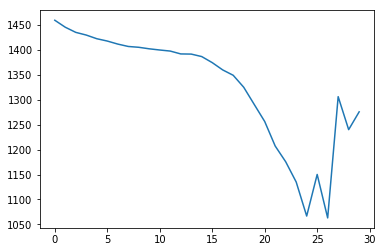

train accuracy: 0.8915
test accuracy: 0.54


In [60]:
main(train, test, word2idx)

vocab size: 18647
start training...
i: 0 cost: 1460.80217306 correct rate: 0.5195 time for epoch: 0:02:10.6304922173
i: 1 cost: 1449.15980441 correct rate: 0.511 time for epoch: 0:02:14.25428959804
i: 2 cost: 1440.38466732 correct rate: 0.5255 time for epoch: 0:02:11.7637874667
i: 3 cost: 1432.54470765 correct rate: 0.524 time for epoch: 0:02:10.13867944708
i: 4 cost: 1425.76541027 correct rate: 0.5255 time for epoch: 0:02:11.9342755410
i: 5 cost: 1419.50605731 correct rate: 0.532 time for epoch: 0:02:11.19405606057
i: 6 cost: 1414.76673592 correct rate: 0.5275 time for epoch: 0:02:12.2452006736
i: 7 cost: 1412.09571433 correct rate: 0.538 time for epoch: 0:02:11.06117595714
i: 8 cost: 1405.08963253 correct rate: 0.5415 time for epoch: 0:02:10.0646759633
i: 9 cost: 1402.19815608 correct rate: 0.5385 time for epoch: 0:02:09.2875948156
i: 10 cost: 1399.67073391 correct rate: 0.554 time for epoch: 0:02:12.35628070734
i: 11 cost: 1399.51205406 correct rate: 0.542 time for epoch: 0:02:08.46

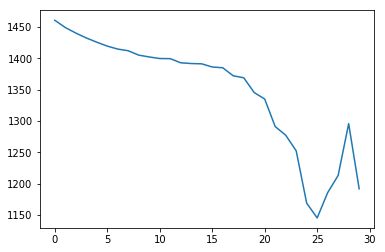

train accuracy: 0.8675
test accuracy: 0.47


In [61]:
main(train, test, word2idx)

train size: 8544
train size after filtering: 6920
vocab size: 18647
start training...
i: 0 cost: 1465.04875003 correct rate: 0.5395 time for epoch: 0:02:01.5850248750
i: 1 cost: 1450.36148985 correct rate: 0.532 time for epoch: 0:02:02.82931361490
i: 2 cost: 1433.09431684 correct rate: 0.544 time for epoch: 0:01:56.45893994317
i: 3 cost: 1423.77550238 correct rate: 0.544 time for epoch: 0:02:02.91361375502
i: 4 cost: 1409.6301581 correct rate: 0.567 time for epoch: 0:01:57.326119630158
i: 5 cost: 1394.29695871 correct rate: 0.5885 time for epoch: 0:01:51.2404916959
i: 6 cost: 1380.0639911 correct rate: 0.6055 time for epoch: 0:01:49.00960263991
i: 7 cost: 1347.07125989 correct rate: 0.643 time for epoch: 0:01:52.91091171260
i: 8 cost: 1303.92347148 correct rate: 0.6755 time for epoch: 0:01:54.7896553471
i: 9 cost: 1245.37716427 correct rate: 0.711 time for epoch: 0:01:56.61170377164
i: 10 cost: 1196.72477884 correct rate: 0.7555 time for epoch: 0:01:48.6706344779
i: 11 cost: 1077.03479

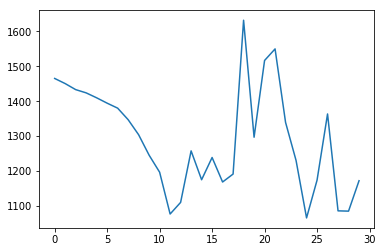

n_correct: 1860 n_total: 2000
train accuracy: 0.93
n_correct: 49 n_total: 100
test accuracy: 0.49


In [12]:
main(train, test, word2idx)

train size: 8544
train size after filtering: 6920
vocab size: 18647
start training...
i: 0 cost: 1464.90537177 correct rate: 0.5245 time for epoch: 0:02:06.8123355372
i: 1 cost: 1447.01542117 correct rate: 0.5415 time for epoch: 0:02:05.4356595421
i: 2 cost: 1435.85772842 correct rate: 0.54 time for epoch: 0:02:15.906302857728
i: 3 cost: 1426.39182028 correct rate: 0.5525 time for epoch: 0:02:19.6105931820
i: 4 cost: 1418.22241086 correct rate: 0.5605 time for epoch: 0:01:56.7302562411
i: 5 cost: 1408.31678211 correct rate: 0.5625 time for epoch: 0:02:08.1775546782
i: 6 cost: 1399.53629127 correct rate: 0.5785 time for epoch: 0:02:08.8536146291
i: 7 cost: 1380.91477138 correct rate: 0.5975 time for epoch: 0:02:00.4760164771
i: 8 cost: 1363.77981981 correct rate: 0.6235 time for epoch: 0:01:58.2916639820
i: 9 cost: 1320.95719659 correct rate: 0.6545 time for epoch: 0:02:01.4695627197
i: 10 cost: 1247.7914676 correct rate: 0.7075 time for epoch: 0:01:59.69681091468
i: 11 cost: 1179.30458

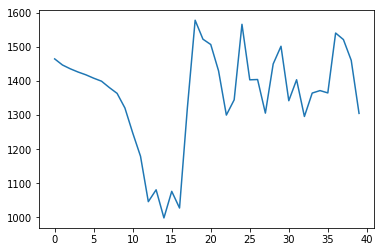

n_correct: 1846 n_total: 2000
train accuracy: 0.923
n_correct: 42 n_total: 100
test accuracy: 0.42


In [27]:
main(train, test, word2idx, dim=10, learning_rate=1e-2, mu=0, epochs=40)

train size: 8544
learning rate: 0.01
regularization: 0.01
mu: 0
eps: 0.01
epochs: 30
dim: 10
train size after filtering: 6920
vocab size: 18647
start training...
i: 0 cost: 1439.61751751 correct rate: 0.507 time for epoch: 0:01:58.18696917518
i:och: 1, j/N: 2000/2000 correct rate so far: 0.546000, cost so far: 1405.852973 1 cost: 1405.85297256 correct rate: 0.546 time for epoch: 0:01:59.402797
i: 2 cost: 1395.33601506 correct rate: 0.5685 time for epoch: 0:02:08.4899076015
i: 3 cost: 1386.35024275 correct rate: 0.619 time for epoch: 0:02:05.09422650243
i: 4 cost: 1367.95842354 correct rate: 0.6695 time for epoch: 0:02:03.3357698424
i: 5 cost: 1290.56921304 correct rate: 0.7175 time for epoch: 0:02:03.5529579213
i: 6 cost: 1024.24686912 correct rate: 0.8695 time for epoch: 0:02:07.3416736869
i: 7 cost: 711.727527239 correct rate: 0.9735 time for epoch: 0:02:06.004034527
i: 8 cost: 564.924944029 correct rate: 0.9915 time for epoch: 0:02:03.742836944
i: 9 cost:j/N: 2000/2000 correct rate 

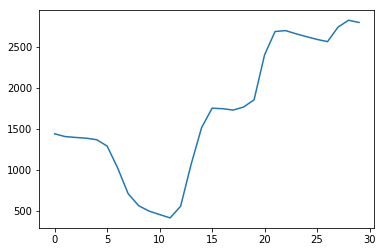

n_correct: 1994 n_total: 2000
train accuracy: 0.997
n_correct: 67 n_total: 100
test accuracy: 0.67


In [49]:
main(train, test, word2idx, dim=10, learning_rate=1e-2, reg=1e-2, mu=0, eps=1e-2, epochs=30, train_inner_nodes=False)

train size: 8544
learning rate: 0.001
regularization: 0.01
mu: 0
eps: 0.01
epochs: 30
dim: 10
train size after filtering: 6920
vocab size: 18647
start training...
i: 0 cost: /N: 2000/2000 correct rate so far: 0.496500, cost so far: 1469.3617201469.36172034 correct rate: 0.4965 time for epoch: 0:01:46.233952
i: 1 cost: 1455.69894092 correct rate: 0.6275 time for epoch: 0:01:42.4595668941
i: 2 cost: 1447.08692396 correct rate: 0.646 time for epoch: 0:01:43.94013886924
i: 3 cost: 1440.08417132 correct rate: 0.6275 time for epoch: 0:01:27.7106394171
i: 4 cost: 1434.12001999 correct rate: 0.628 time for epoch: 0:01:29.34788020020
i: 5 cost: 1428.8660023 correct rate: 0.608 time for epoch: 0:01:34.864721866002
i: 6 cost: 1424.08839762 correct rate so far: 0.623500, cost so far: 1424.088398correct rate: 0.6235 time for epoch: 0:01:41.659534
i: 7 cost: 1419.56517705 correct rate: 0.6175 time for epoch: 0:01:41.7609105177
i: 8 cost:j/N: 2000/2000 correct rate so far: 0.641500, cost so far: 1415

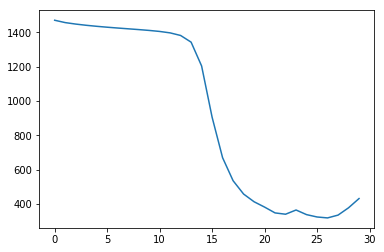

n_correct: 1932 n_total: 2000
train accuracy: 0.966
n_correct: 50 n_total: 100
test accuracy: 0.5


In [50]:
main(train, test, word2idx, dim=10, learning_rate=1e-3, reg=1e-2, mu=0, eps=1e-2, epochs=30, train_inner_nodes=False)

learning rate: 0.01
regularization: 0.01
mu: 0
eps: 0.0001
epochs: 30
dim: 20
total train size after filtering: 6920
train size: 5000
test size: 1000
vocab size: 18647
start training...
i: 0 cost: 3850.51820355 correct rate: 0.5204 time for epoch: 0:13:06.8171948204
i: 1 cost: 3645.3888519 correct rate: 0.5422 time for epoch: 0:13:23.87749388852
i: 2 cost: 3594.99113639 correct rate: 0.5504 time for epoch: 0:13:30.7084431136
i: 3 cost: 3575.92290175 correct rate: 0.5504 time for epoch: 0:13:31.2074942902
i: 4 cost: 3561.7449655 correct rate: 0.5574 time for epoch: 0:13:27.49487544966
i: 5 cost: 3552.45739013 correct rate: 0.5608 time for epoch: 0:13:28.6522957390
i: 6 cost: 3545.2423353 correct rate: 0.5658 time for epoch: 0:13:19.40446942335
i: 7 cost: 3538.72302939 correct rate: 0.5676 time for epoch: 0:13:29.0104713029
i: 8 cost: 3533.01091475 correct rate: 0.5714 time for epoch: 0:13:27.2114490915
i: 9 cost: 3528.14759502 correct rate: 0.5774 time for epoch: 0:13:28.4058367595
i: 1

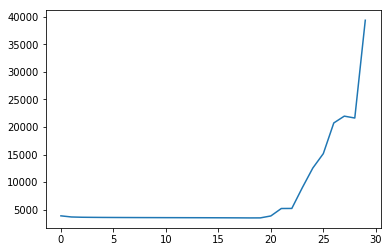

n_correct: 4873 n_total: 5000
train accuracy: 0.9746
n_correct: 554 n_total: 1000
test accuracy: 0.554


In [60]:
main(train, test, word2idx, dim=10, learning_rate=1e-2, reg=1e-2, mu=0, eps=1e-4, epochs=30, train_inner_nodes=False)

learning rate: 0.01
regularization: 0.01
mu: 0
eps: 0.0001
epochs: 30
dim: 20
total train size after filtering: 6920
train size: 5000
test size: 1000
vocab size: 18647
start training...
i: 0 cost: 24673.6382864 xent 3695.19550228 correct rate: 0.5182 time for epoch: 0:13:05.740292 3695.195502
i: 1 cost: 19261.6060368 xent 3364.25602325 correct rate: 0.5818 time for epoch: 0:13:23.912292 3364.256023
i: 2 cost: 15566.5552095 xent 3366.99434456 correct rate: 0.5888 time for epoch: 0:13:36.026394 3366.994345
i: 3 cost: 13356.9511281 xent 3358.75845778 correct rate: 0.584 time for epoch: 0:16:46.684883: 3358.758458
i: 4 cost: 11841.8668446 xent 3343.50185525 correct rate: 0.591 time for epoch: 0:14:58.589859: 3343.501855
i: 5 cost: 10717.3366771 xent 3324.46209496 correct rate: 0.5998 time for epoch: 0:11:33.925472 3324.462095
i: 6 cost: 9842.41904691 xent 3297.91330834 correct rate: 0.6054 time for epoch: 0:11:22.7615173297.913308
i: 7 cost: 9134.26961971 xent 3261.57287381 correct rate: 0

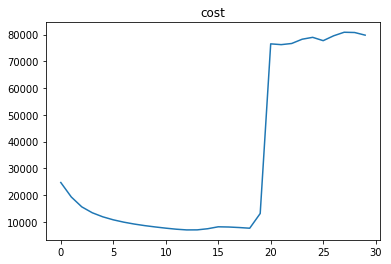

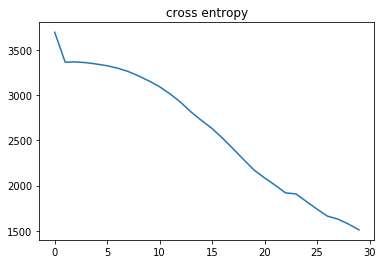

n_correct: 4497 n_total: 5000
train accuracy: 0.8994
n_correct: 503 n_total: 1000
test accuracy: 0.503


In [63]:
main(train, test, word2idx, dim=20, learning_rate=1e-2, reg=1e-2, mu=0, eps=1e-4, epochs=30, train_inner_nodes=False)

learning rate: 0.01
regularization: 0.1
mu: 0
eps: 0.0001
epochs: 30
dim: 20
total train size after filtering: 6920
train size: 5000
test size: 1000
vocab size: 18647
start training...
i: 0 cost: 4358.59588602 xent 3475.60167104 correct rate: 0.5184 time for epoch: 0:13:02.9661643475.601671
i: 1 cost: 3706.19565802 xent 3461.05033083 correct rate: 0.5198 time for epoch: 0:13:01.0960933461.050331
i:och: 2, j/N: 5000/5000 correct rate so far: 0.528000, cost so far: 3628.790584, xent so far: 3461.364870 2 cost: 3628.7905839 xent 3461.36487027 correct rate: 0.528 time for epoch: 0:13:58.237903
i: 3 cost: 3595.35207884 xent 3461.33806017 correct rate: 0.5288 time for epoch: 0:13:39.6066133461.338060
i: 4 cost: 3575.58248549 xent 3459.70234676 correct rate: 0.5284 time for epoch: 0:13:40.2655503459.702347
i: 5 cost: 3562.82873388 xent 3460.19677042 correct rate: 0.528 time for epoch: 0:13:45.663196 3460.196770
i: 6 cost: 3553.2454185 xent 3462.12779574 correct rate: 0.522 time for epoch: 0:1

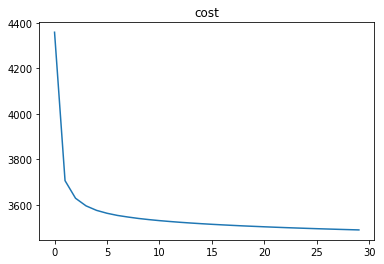

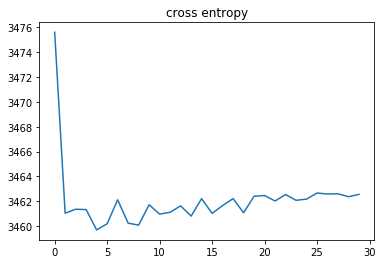

n_correct: 2605 n_total: 5000
train accuracy: 0.521
n_correct: 512 n_total: 1000
test accuracy: 0.512


In [64]:
main(train, test, word2idx, dim=20, learning_rate=1e-2, reg=1e-1, mu=0, eps=1e-4, epochs=30, train_inner_nodes=False)

learning rate: 0.01
regularization: 0.01
mu: 0
eps: 0.01
epochs: 30
dim: 10
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
start training...
i: 0 cost: 5482.65487459 xent 4802.14066276 correct rate: 0.5315028901734105 time for epoch: 0:06:16.336058
i: 1 cost: 5104.997311 xent 4735.45567087 correct rate: 0.5687861271676301 time for epoch: 0:06:32.8343331
i: 2 cost: 4970.39812678 xent 4740.62977631 correct rate: 0.5677745664739884 time for epoch: 0:06:54.107279
i: 3 cost: 4928.80958057 xent 4739.91252339 correct rate: 0.5596820809248555 time for epoch: 0:06:06.933779
i: 4 cost: 4908.23827347 xent 4737.57250704 correct rate: 0.5705202312138729 time for epoch: 0:05:34.753163
i: 5 cost: 4894.37916079 xent 4733.20462558 correct rate: 0.5622832369942197 time for epoch: 0:06:36.447184
i: 6 cost: 4888.32175735 xent 4733.03910387 correct rate: 0.5653179190751445 time for epoch: 0:06:25.537861
i: 7 cost: 4880.64957976 xent 4729.33412423 correct rate: 0.5

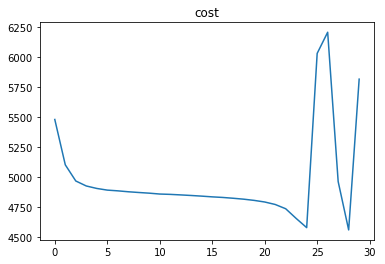

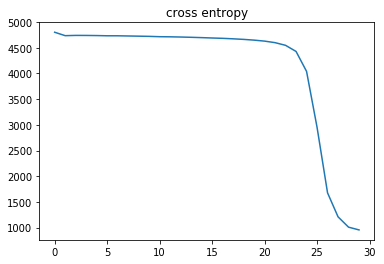

n_correct: 6766 n_total: 6920
train accuracy: 0.9777456647398844
n_correct: 753 n_total: 1000
test accuracy: 0.753


In [18]:
main(train, test, word2idx, dim=10, learning_rate=1e-2, reg=1e-2, mu=0, eps=1e-2, activation=T.tanh, epochs=30, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1821
vocab size: 18647
learning rate: 0.01
regularization: 0.01
mu: 0
eps: 0.01
epochs: 40
decay_rate: 0.999
dim: 10
activation:  <class 'theano.tensor.elemwise.Elemwise'>
train_inner_nodes:  False
start training...
i: 0 cost: 5562.44039396 xent 4862.0542258 correct rate: 0.5170520231213873 time for epoch: 0:06:53.582686
i: 1 cost: 5087.87623376 xent 4755.15036177 correct rate: 0.5391618497109827 time for epoch: 0:07:01.460412
i: 2 cost: 4963.70693927 xent 4759.51729019 correct rate: 0.5417630057803469 time for epoch: 0:08:00.238010
i: 3 cost: 4928.95085563 xent 4756.39909504 correct rate: 0.5407514450867053 time for epoch: 0:07:01.640497
i: 4 cost: 4912.41954034 xent 4753.34860001 correct rate: 0.551878612716763 time for epoch: 0:07:14.708346
i: 5 cost: 4901.11755827 xent 4749.89430203 correct rate: 0.5596820809248555 time for epoch: 0:07:47.691426
i: 6 cost: 4893.52967378 xent 4

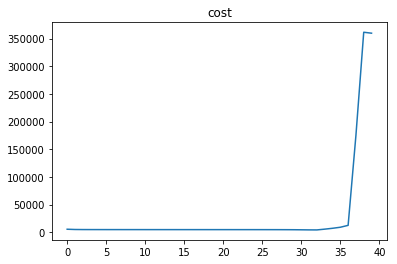

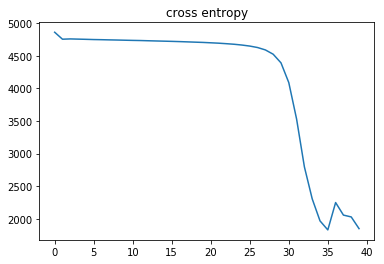

n_correct: 6426 n_total: 6920
train accuracy: 0.9286127167630058
n_correct: 941 n_total: 1821
test accuracy: 0.5167490389895661


In [30]:
main(train, test, word2idx, dim=10, learning_rate=1e-2, reg=1e-2, mu=0, eps=1e-2, activation=T.tanh, epochs=40, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 25
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5019.41520957 xent 4787.19678268 correct rate: 0.5202312138728323 time for epoch: 0:06:53.093482
n_correct: 85 n_total: 200
test accuracy: 0.425 best test accuracy so far: 0.425
i: 1 cost: 4939.01689304 xent 4780.70752445 correct rate: 0.5260115606936416 time for epoch: 0:07:11.609021
n_correct: 86 n_total: 200
test accuracy: 0.43 best test accuracy so far: 0.43
i: 2 cost: 4891.15018587 xent 4778.59343457 correct rate: 0.5247109826589595 time for epoch: 0:07:42.620232
n_correct: 87 n_total: 200
test accuracy: 0.435 best test accuracy so far: 0.435
i: 3 cost: 4860.60580957 xent 4776.86612969 correct rate: 0.5294797687861271 time for epoch: 0:06:54.398929
n_correct: 89 n_total: 200
test accuracy: 0.445 best test

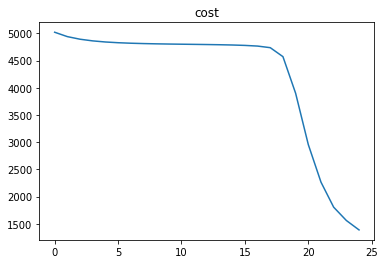

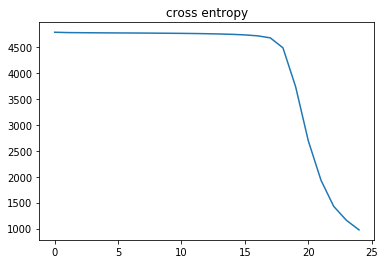

n_correct: 6746 n_total: 6920
train accuracy: 0.9748554913294798
n_correct: 742 n_total: 1000
test accuracy: 0.742


In [48]:
main(train, test, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=25, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 35
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5018.13088184 xent 4780.20939776 correct rate: 0.5286127167630058 time for epoch: 0:06:59.034500
n_correct: 99 n_total: 200
test accuracy: 0.495 best test accuracy so far: 0.495
i: 1 cost: 4930.79892088 xent 4763.6181628 correct rate: 0.5502890173410404 8921, xent so far: 4763.618163time for epoch: 0:06:31.266143
n_correct: 93 n_total: 200
test accuracy: 0.465 best test accuracy so far: 0.495
i: 2 cost: 4876.6148674 xent 4748.84535823 correct rate: 0.5625722543352601 time for epoch: 0:06:26.646511
n_correct: 85 n_total: 200
test accuracy: 0.425 best test accuracy so far: 0.495
i: 3 cost: 4836.76654141 xent 4730.35460867 correct rate: 0.5771676300578035 time for epoch: 0:06:22.375885
n_correct: 98 n_total: 200


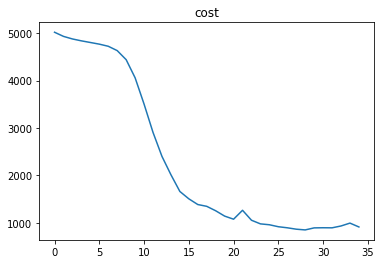

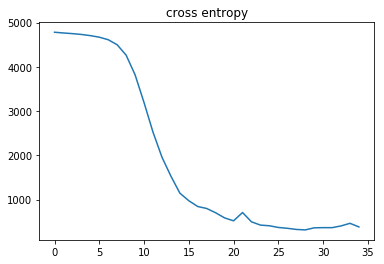

n_correct: 6873 n_total: 6920
train accuracy: 0.9932080924855491
n_correct: 518 n_total: 1000
test accuracy: 0.518


In [50]:
main(train, test, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=35, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 35
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5001.60752328 xent 4786.27918869 correct rate: 0.5229768786127168 time for epoch: 0:07:46.583270
n_correct: 94 n_total: 200
test accuracy: 0.47 best test accuracy so far: 0.47
i: 1 cost: 4924.46290221 xent 4778.35006629 correct rate: 0.52875722543352662902, xent so far: 4778.350066 time for epoch: 0:07:09.376781
n_correct: 97 n_total: 200
test accuracy: 0.485 best test accuracy so far: 0.485
i: 2 cost: 4879.48620688 xent 4775.39677783 correct rate: 0.5332369942196532 time for epoch: 0:06:20.662043
n_correct: 97 n_total: 200
test accuracy: 0.485 best test accuracy so far: 0.485
i: 3 cost: 4850.94561912 xent 4773.12834187 correct rate: 0.5393063583815029 time for epoch: 0:06:27.371355
n_correct: 97 n_total: 200


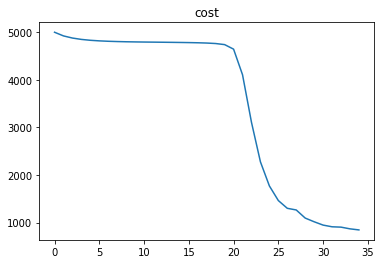

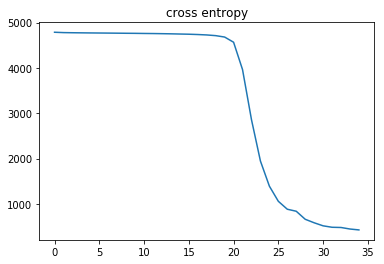

n_correct: 6838 n_total: 6920
train accuracy: 0.988150289017341
n_correct: 733 n_total: 1000
test accuracy: 0.733


In [51]:
main(train, test, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=35, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 35
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5019.35443731 xent 4784.50351566 correct rate: 0.525578034682081 time for epoch: 0:07:39.213775
n_correct: 495 n_total: 1000
test accuracy: 0.495 best test accuracy so far: 0.495
i: 1 cost: 4935.25632091 xent 4769.99239877 correct rate: 0.5342485549132948 time for epoch: 0:07:58.383422
n_correct: 507 n_total: 1000
test accuracy: 0.507 best test accuracy so far: 0.507
i: 2 cost: 4889.15174345 xent 4764.46604828 correct rate: 0.5398843930635838 time for epoch: 0:07:19.493115
n_correct: 516 n_total: 1000
test accuracy: 0.516 best test accuracy so far: 0.516
i: 3 cost: 4859.83847808 xent 4759.74574708 correct rate: 0.5580924855491329 time for epoch: 0:08:56.791586
n_correct: 503 n_total: 1000
test accuracy: 0.503 

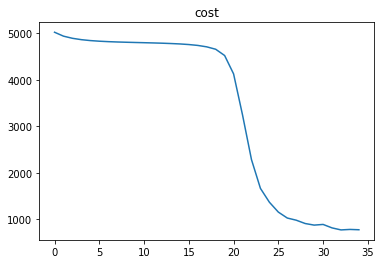

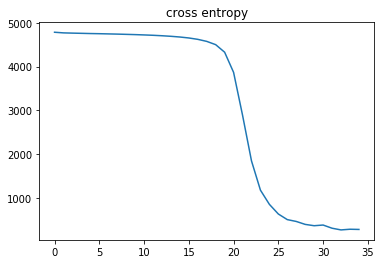

n_correct: 6900 n_total: 6920
train accuracy: 0.9971098265895953
n_correct: 734 n_total: 1000
test accuracy: 0.734


In [56]:
main(train, test, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=35, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 35
decay_rate: 0.999
dim: 20
train_inner_nodes:  False
start training...
i: 0 cost: 5279.31515972 xent 4784.88851295 correct rate: 0.5242774566473989 time for epoch: 0:15:34.248572
n_correct: 483 n_total: 1000
test accuracy: 0.483 best test accuracy so far: 0.483
i: 1 cost: 5107.63644648 xent 4775.00001707 correct rate: 0.5354046242774566 time for epoch: 0:17:13.007232
n_correct: 494 n_total: 1000
test accuracy: 0.494 best test accuracy so far: 0.494
i: 2 cost: 5003.16515819 xent 4771.60363893 correct rate: 0.5426300578034682 time for epoch: 0:16:07.554360
n_correct: 499 n_total: 1000
test accuracy: 0.499 best test accuracy so far: 0.499
i: 3 cost: 4935.59010887 xent 4769.14742726 correct rate: 0.5478323699421965 time for epoch: 0:16:38.555291
n_correct: 505 n_total: 1000
test accuracy: 0.505

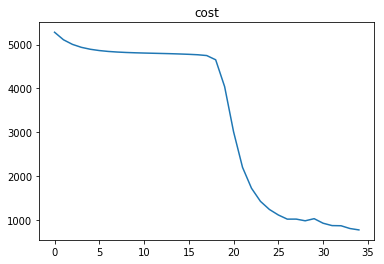

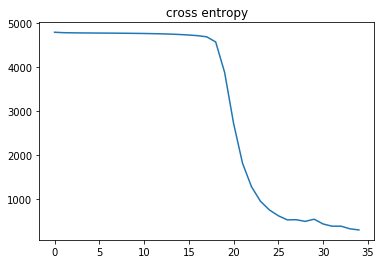

n_correct: 6881 n_total: 6920
train accuracy: 0.994364161849711
n_correct: 722 n_total: 1000
test accuracy: 0.722


In [57]:
main(train, test, word2idx, dim=20, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=35, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 40
decay_rate: 0.999
dim: 15
train_inner_nodes:  False
start training...
i: 0 cost: 5120.80436807 xent 4783.89951457 correct rate: 0.5213872832369942 time for epoch: 0:13:00.145229
n_correct: 514 n_total: 1000
test accuracy: 0.514 best test accuracy so far: 0.514
i: 1 cost: 5004.61030258 xent 4776.78447302 correct rate: 0.5239884393063584 time for epoch: 0:12:22.947233
n_correct: 516 n_total: 1000
test accuracy: 0.516 best test accuracy so far: 0.516
i: 2 cost: 4933.28897888 xent 4773.26726183 correct rate: 0.5436416184971098 time for epoch: 0:11:11.232961
n_correct: 513 n_total: 1000
test accuracy: 0.513 best test accuracy so far: 0.516
i: 3 cost: 4887.54187261 xent 4770.81130797 correct rate: 0.536271676300578 time for epoch: 0:10:56.209324
n_correct: 519 n_total: 1000
test accuracy: 0.519 

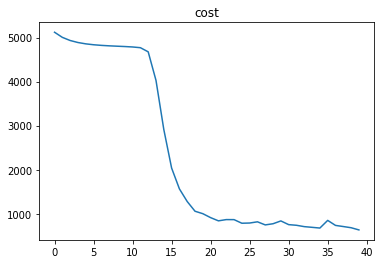

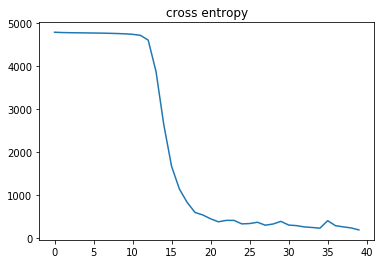

n_correct: 6901 n_total: 6920
train accuracy: 0.9972543352601156
n_correct: 722 n_total: 1000
test accuracy: 0.722


In [60]:
main(train, test, word2idx, dim=15, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=40, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 40
decay_rate: 0.999
dim: 7
train_inner_nodes:  False
start training...
i: 0 cost: 4976.88097414 xent 4788.12552765 correct rate: 0.5219653179190752 time for epoch: 0:04:11.602943
n_correct: 499 n_total: 1000
test accuracy: 0.499 best test accuracy so far: 0.499
i: 1 cost: 4909.80634705 xent 4778.53491228 correct rate: 0.5235549132947976 time for epoch: 0:04:54.606793
n_correct: 500 n_total: 1000
test accuracy: 0.5 best test accuracy so far: 0.5
i: 2 cost: 4872.05999243 xent 4775.45198144 correct rate: 0.5241329479768786 time for epoch: 0:05:41.815129
n_correct: 506 n_total: 1000
test accuracy: 0.506 best test accuracy so far: 0.506
i: 3 cost: 4848.17918296 xent 4772.83193857 correct rate: 0.5267341040462428 time for epoch: 0:04:28.994135
n_correct: 506 n_total: 1000
test accuracy: 0.506 best

n_correct: 722 n_total: 1000
test accuracy: 0.722 best test accuracy so far: 0.766
best test accuracy: 0.766


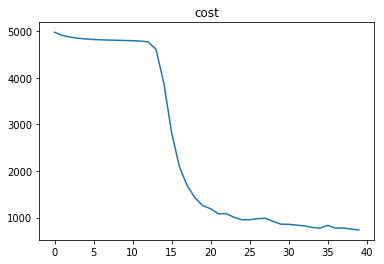

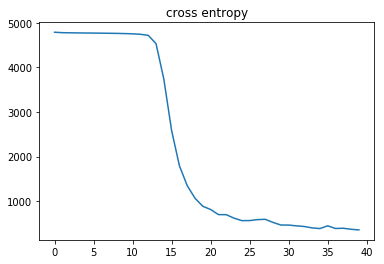

n_correct: 6870 n_total: 6920
train accuracy: 0.9927745664739884
n_correct: 722 n_total: 1000
test accuracy: 0.722


In [62]:
main(train, test, word2idx, dim=7, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=40, train_inner_nodes=False)

total train size before filtering: 8544
total train size after filtering: 6920
train size: 6920
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 40
decay_rate: 0.999
dim: 12
train_inner_nodes:  False
start training...
i: 0 cost: 5055.05600125 xent 4786.34559107 correct rate: 0.5205202312138728 time for epoch: 0:06:49.738959
n_correct: 508 n_total: 1000
test accuracy: 0.508 best test accuracy so far: 0.508
i: 1 cost: 4959.35770135 xent 4778.75521067 correct rate: 0.5358381502890174 time for epoch: 0:07:02.553027
n_correct: 505 n_total: 1000
test accuracy: 0.505 best test accuracy so far: 0.508
i: 2 cost: 4902.95317347 xent 4776.67427861 correct rate: 0.5346820809248555 time for epoch: 0:06:54.090098
n_correct: 518 n_total: 1000
test accuracy: 0.518 best test accuracy so far: 0.518
i: 3 cost: 4866.60228743 xent 4775.04290771 correct rate: 0.5426300578034682 time for epoch: 0:07:32.435235
n_correct: 523 n_total: 1000
test accuracy: 0.523

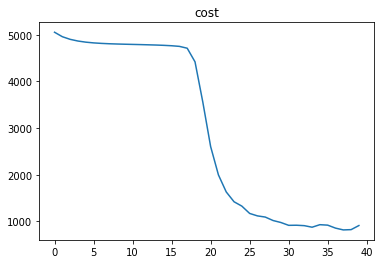

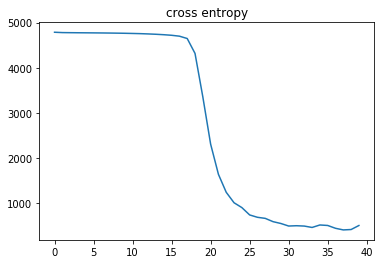

n_correct: 6856 n_total: 6920
train accuracy: 0.9907514450867052
n_correct: 713 n_total: 1000
test accuracy: 0.713


In [64]:
main(train, test, word2idx, dim=12, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=40, train_inner_nodes=False)

In [ ]:
main(train, test, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=35, train_inner_nodes=False)

total train size before filtering: 9544
total train size after filtering: 7739
train size: 7739
test size: 1000
vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 35
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5606.26045475 xent 5351.58869112 correct rate: 0.5209975449024422 time for epoch: 0:07:11.108013
n_correct: 506 n_total: 1000
test accuracy: 0.506 best test accuracy so far: 0.506
i: 1 cost: 5507.85330666 xent 5338.6001544 correct rate: 0.5446440108541155 time for epoch: 0:06:40.871499
n_correct: 506 n_total: 1000
test accuracy: 0.506 best test accuracy so far: 0.506
i: 2 cost: 5454.61627167 xent 5332.64071182 correct rate: 0.5443855795322393 time for epoch: 0:07:16.801339
n_correct: 519 n_total: 1000
test accuracy: 0.519 best test accuracy so far: 0.519
i: 3 cost: 5421.21869076 xent 5326.07370435 correct rate: 0.550071068613516 time for epoch: 0:07:46.502686
n_correct: 498 n_total: 1000
test accuracy: 0.498 b